In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

#from multi_run.backtest_v3 import simulate_longonly, simulate_longshort
from multi_run.backtest_daily import simulate_longonly_d, simulate_longshort_d
from multi_run.initialize_v2 import data_pp
from multi_run.momentum_strategy_v3 import weekly_momentum_value_weighted

2023-05-17 10:08:22,285	INFO worker.py:1625 -- Started a local Ray instance.
2023-05-17 10:08:26,049	INFO worker.py:1454 -- Calling ray.init() again after it has already been called.


In [2]:
cmktcap = pd.read_pickle("Data/cmktcap_data_final.pickle")
cmkt_data = data_pp(cmktcap, vender="coinmarketcap")

#binance = pd.read_pickle("Data/binance_data_pp.pickle")
#cmkt_data = data_pp(binance, vender="binance")

In [3]:
daily_rtn = cmkt_data["price"].pct_change(fill_method=None)

In [ ]:
inner = weekly_momentum_value_weighted(price_df=cmkt_data["price"],
                                        mktcap_df=cmkt_data["mktcap"],
                                        vol_df=cmkt_data["vol"], 
                                        n_group=5,
                                        day_of_week="SUN",
                                        number_of_coin_group=20, 
                                        mktcap_thresh=1_000_000,
                                        vol_thresh=1_000_000,
                                        freq="Daily")
# daily_rtn_df, mktcap_used, group_mask_dict

In [85]:
def simulate_longshort_d(long_weight_df:pd.DataFrame, short_weight_df:pd.DataFrame, daily_rtn_df:pd.DataFrame, fee_rate:float, margin:str):
    '''
    전략의 수익을 평가합니다 (long-short Portfolio)
    margin (str) : ["isolate","cross"]
    
    Short을 반대의 수익을 주는 하나의 상품이라 생각하고 접근
    
    Daily로 1/7씩 진입
    '''
    start_idx = long_weight_df.index[0]        
    
    # Initial value setting   
    asset_value = 0
    pf_dict = {}
    #cash = 6/7 # 첫날 투자해서 Cash 1/7은 이미 빠져나감
    pf_value = 1 # 현금+자산가치로 1이된다
    
    # 시작 weight를 지정해준다(첫 weight에서 투자 시작, 장마감 직전에 포트폴리오 구성)
    short_weight = short_weight_df.iloc[0]
    long_weight = long_weight_df.iloc[0]  
    
    # 최초 Dollar Value 할당 / 투자 첫날
    dollar_value_of_sell = (short_weight * 0.5/7) 
    dollar_value_of_buy  = (long_weight * 0.5/7)  # dollar_value_of_sell - dollar_value_of_buy=0 성립
    dollar_value_of_sell = dollar_value_of_sell * (1-fee_rate) # fee 차감
    dollar_value_of_buy = dollar_value_of_buy * (1-fee_rate) 
    
    # 공매도는 음수, 매수는 양수로 DV가 찍혀있다
    #dollar_value_array = np.nan_to_num(dollar_value_of_sell) + np.nan_to_num(dollar_value_of_buy)
    
    first_week_start = start_idx + pd.Timedelta(days=1)
    first_week_end = start_idx + pd.Timedelta(days=6)
    
    # 첫 6일간 1/7씩 계속 진입해야한다
    for idx, row in daily_rtn_df.loc[first_week_start:].iterrows(): # Daily로 반복 / 시작 weight 구성 다음 날부터 성과를 평가
        #dollar_value_array_update = dollar_value_array * (1+np.nan_to_num(row)) # 수익률 변화 기록
        dollar_value_of_sell_update = dollar_value_of_sell * (1 + np.nan_to_num(-row)) # position 잡고 있는 애들은 가격 변화를 기록
        dollar_value_of_buy_update  = dollar_value_of_buy * (1 + np.nan_to_num(row)) 
        
        dollar_gain_sell = dollar_value_of_sell_update - dollar_value_of_sell
        dollar_gain_buy = dollar_value_of_buy_update - dollar_value_of_buy
        total_dollar_gain = np.nan_to_num(dollar_gain_buy) + np.nan_to_num(dollar_gain_sell)
        
        pf_value = pf_value + np.nansum(total_dollar_gain) # pf_Value 변화 기록
        print(idx, pf_value)
        
        today_short_weight = short_weight_df.loc[idx] 
        today_long_weight = long_weight_df.loc[idx]
        
        new_dollar_value_of_sell = np.nan_to_num(today_short_weight * 0.5/7) * (1-fee_rate) # 신규 진입
        new_dollar_value_of_buy =  np.nan_to_num(today_long_weight * 0.5/7) * (1-fee_rate)
        
        dollar_value_of_sell = new_dollar_value_of_sell + np.nan_to_num(dollar_value_of_sell) # 신규 진입 반영
        dollar_value_of_buy = new_dollar_value_of_buy + np.nan_to_num(dollar_value_of_buy)
        
        
        #cash -= 1/7 

In [86]:
a = simulate_longshort_d(inner[4], 
                         inner[0],         
                    daily_rtn,
                    0.0015,
                    "isolate")

2017-12-03 00:00:00 0.999525860522802
2017-12-04 00:00:00 1.023083860306276
2017-12-05 00:00:00 1.0674583244007614
2017-12-06 00:00:00 1.1050109485328887
2017-12-07 00:00:00 1.101407447758123
2017-12-08 00:00:00 1.1096783419233691
2017-12-09 00:00:00 1.0953957787068502
2017-12-10 00:00:00 1.0914422919514146
2017-12-11 00:00:00 1.0924388363590514
2017-12-12 00:00:00 1.0457066001603867
2017-12-13 00:00:00 0.9903999633831588
2017-12-14 00:00:00 0.8592076702375037
2017-12-15 00:00:00 0.9051877984914605
2017-12-16 00:00:00 0.906910283338247
2017-12-17 00:00:00 0.8776005555013524
2017-12-18 00:00:00 0.8301410629958953
2017-12-19 00:00:00 0.8003004534939945
2017-12-20 00:00:00 0.6383878347244472
2017-12-21 00:00:00 0.7069507321974167
2017-12-22 00:00:00 0.7160296311967882
2017-12-23 00:00:00 0.7115534395697201
2017-12-24 00:00:00 0.7189231890942143
2017-12-25 00:00:00 0.7346729612181148
2017-12-26 00:00:00 0.71702397352044
2017-12-27 00:00:00 0.7301853528532061
2017-12-28 00:00:00 0.787205072

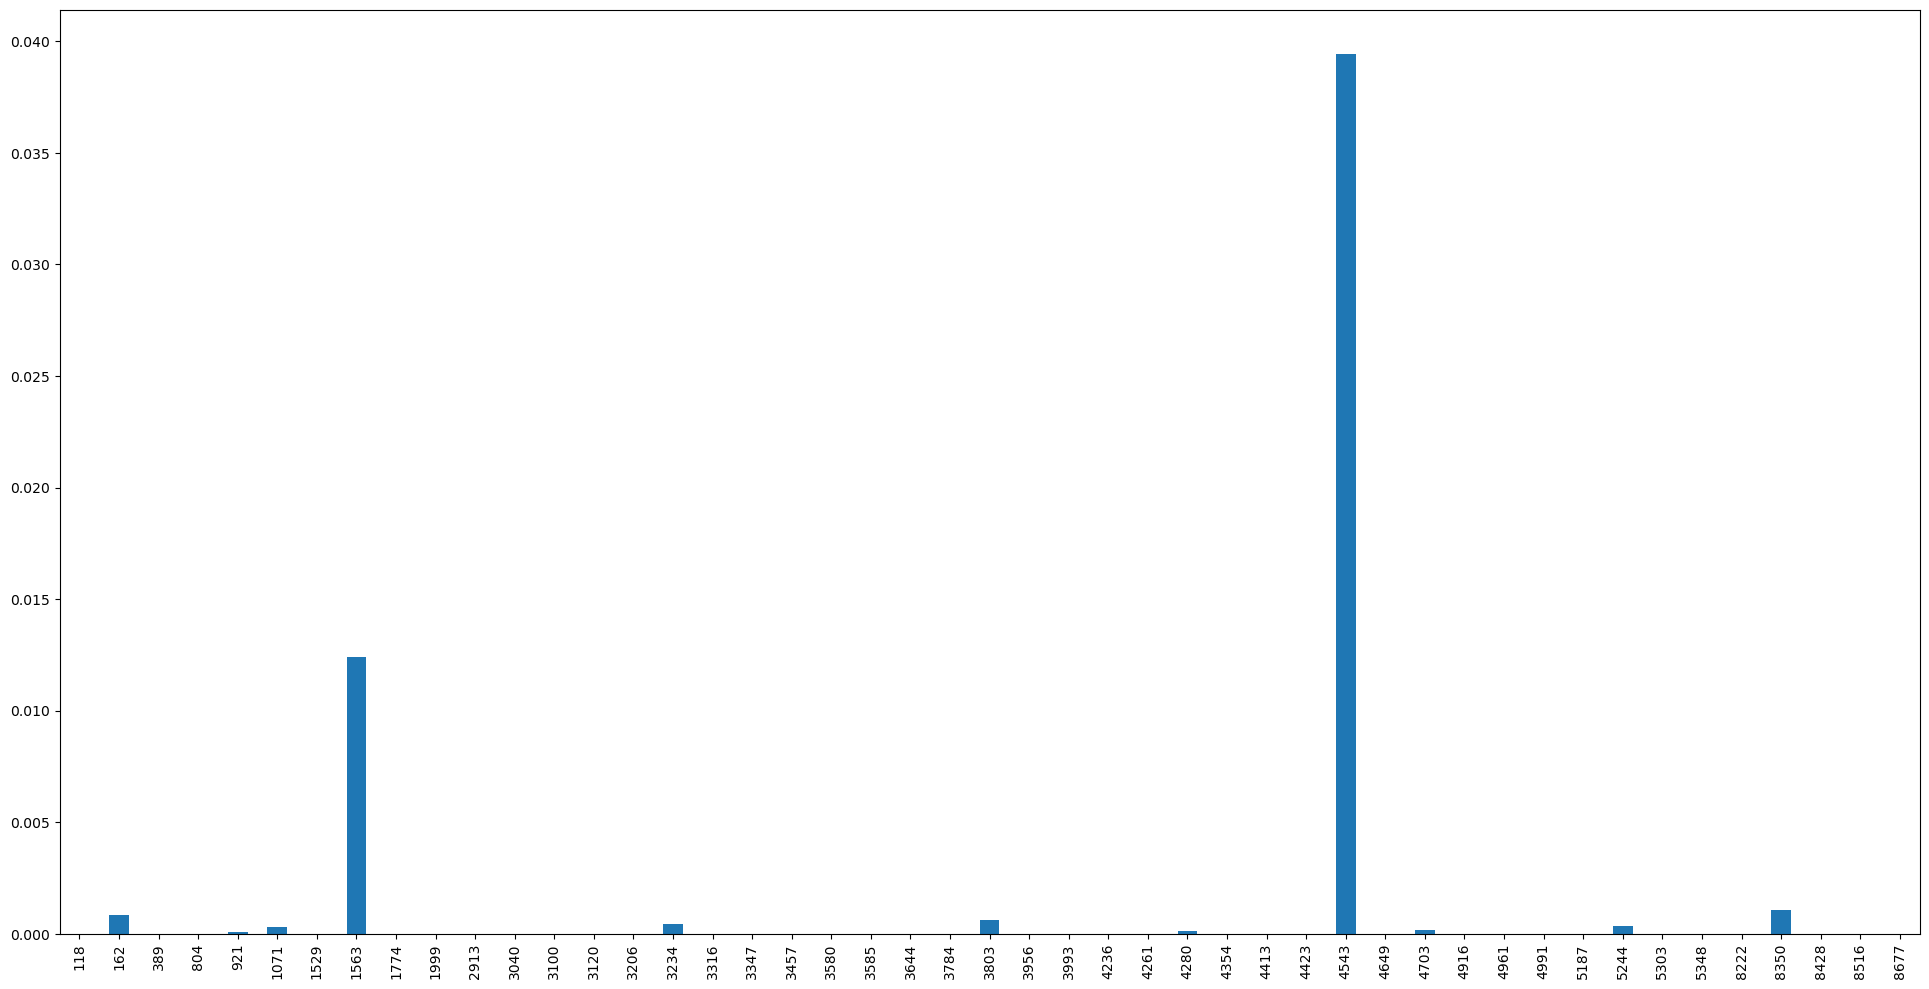

In [33]:
sample = pd.Series(a[0])
sample2 = pd.Series(a[1])
#sample2.loc[sample2.values > 0].plot(kind="bar", figsize=(24,12))
sample.loc[sample2.values > 0].plot(kind="bar", figsize=(24,12), subplots=True);

<AxesSubplot:>

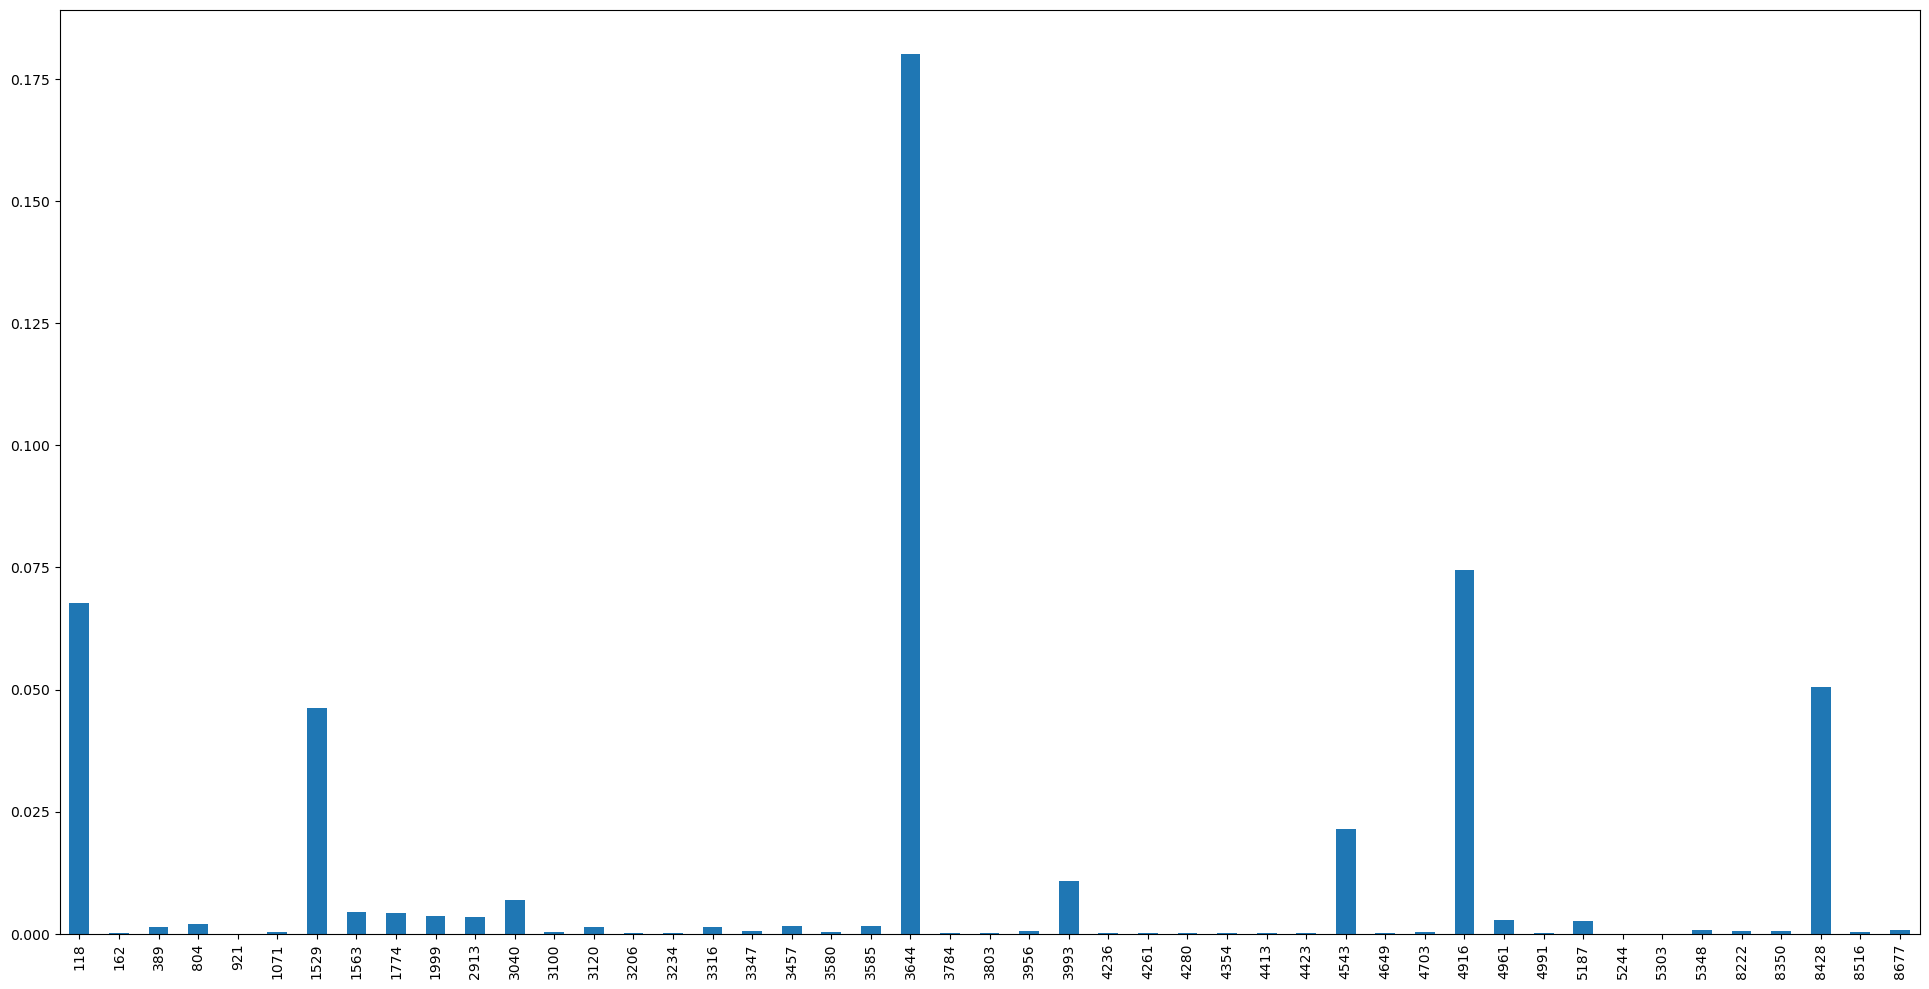

In [34]:
sample2.loc[sample2.values > 0].plot(kind="bar", figsize=(24,12))

In [47]:
# 위치를 학인해야한다

bol1 = (a[0] != 0)
bol2 = (a[1] != 0)

In [61]:
np.sum(bol1) + np.sum(bol2)

93

In [64]:
np.sum(bol1 + bol2)

82

In [49]:
bol1

array([ True, False, False, ..., False, False, False])

In [17]:
np.nansum(a[0]) #+ np.nansum(a[1])

0.6427678190511318

<AxesSubplot:>

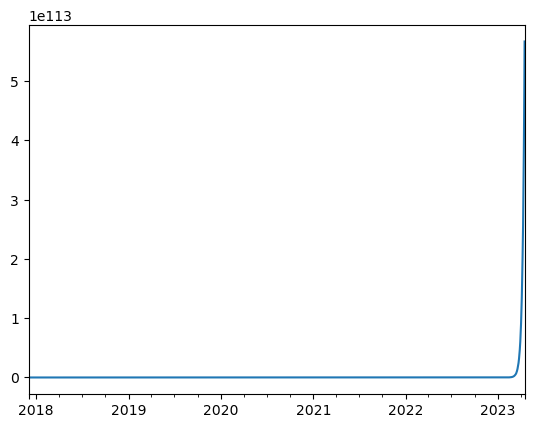

In [74]:
pd.Series(a).plot()

<AxesSubplot:>

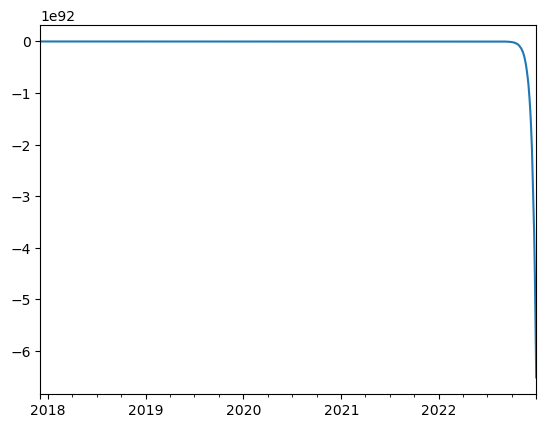

In [55]:
pd.Series(a).loc[:"2022"].plot()

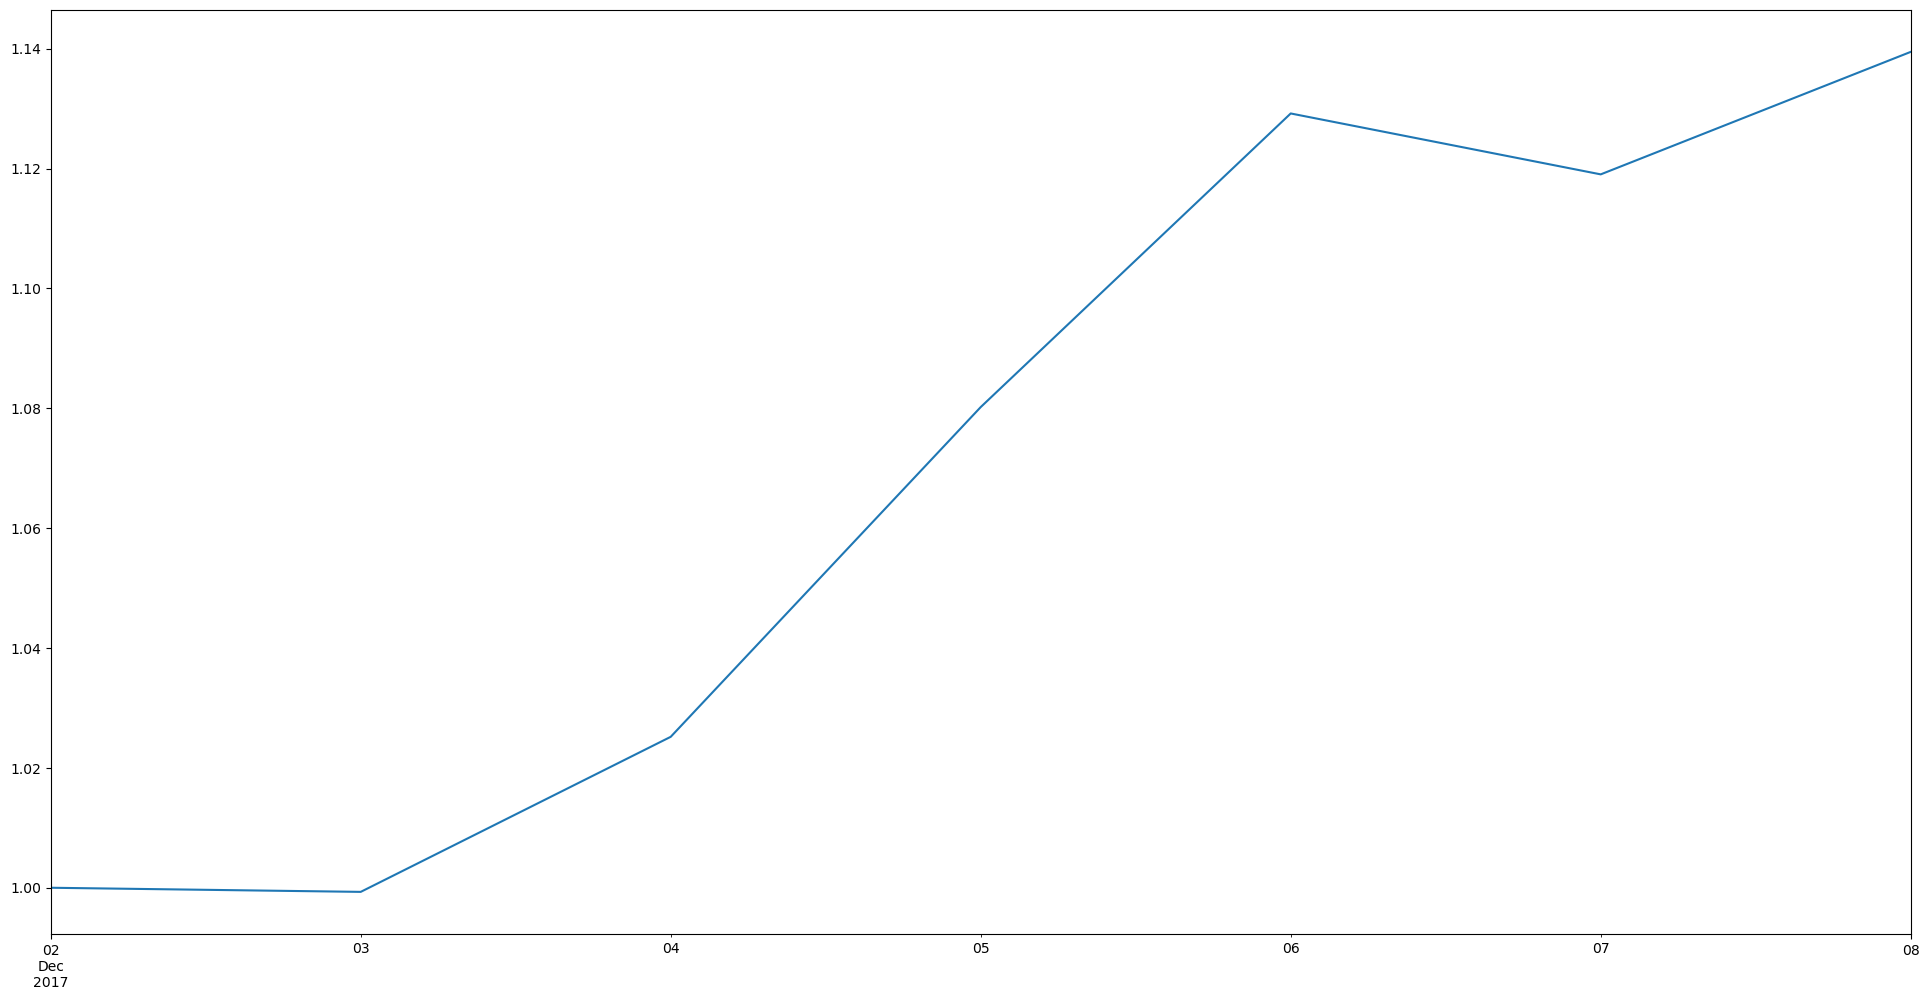

In [43]:
pd.Series(a).iloc[:7].plot(figsize=(24,12));

<AxesSubplot:>

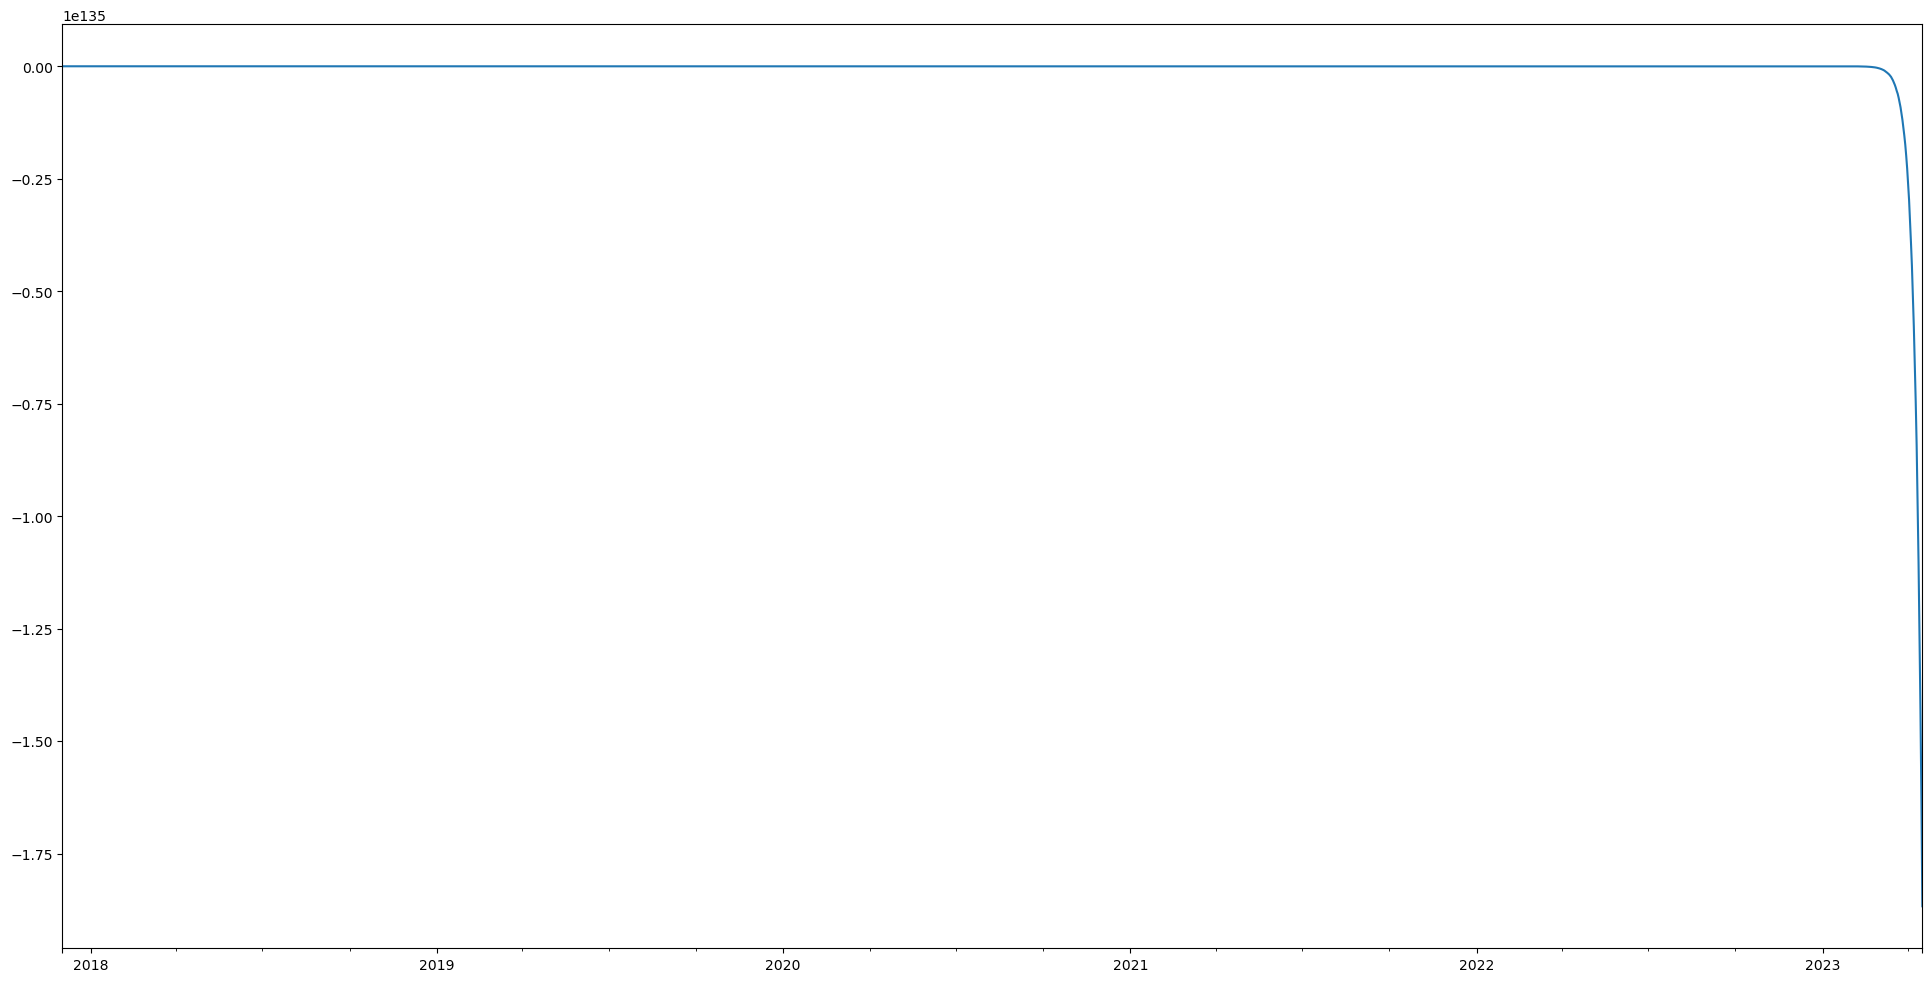

In [38]:
pd.Series(a).plot(figsize=(24,12))#.plot(figsize=(24,12));